In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !git clone https://github.com/MJC598/Neuron_Burst_Analysis.git

In [2]:
%matplotlib notebook
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io
import random
import time
import pandas as pds
from sklearn.metrics import r2_score

torch.manual_seed(0)

In [3]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        out = self.fc2(x)
        return out

In [4]:
TIMESTEPS = 85
FRONT_TIME = -50
BACK_TIME = 40
T_START = 50+FRONT_TIME
T_END = 50+BACK_TIME
MODEL = FCN
OUTPUT = 'FR_LFP'
LOSS_FILE = ('losses/bursts/losses_' + str(MODEL) + 
             '_' + OUTPUT + '_' + str(FRONT_TIME) + 
             '_' + str(T_END) + '_10ms_lag_full.csv')
PATH = ('models/bursts/' + str(MODEL) + '_' + OUTPUT + 
        '_' + str(FRONT_TIME) + '_' + str(T_END) + 
        '_10ms_lag_full.pth')
DATA_PATH = 'data/bursts/burst_separatePNITNv2.mat'
COLAB_PRE = 'Neuron_Burst_Analysis/'
if RunningInCOLAB:
    LOSS_FILE = COLAB_PRE + LOSS_FILE
    PATH = COLAB_PRE + PATH
    DATA_PATH = COLAB_PRE + DATA_PATH

# Specific Model Parameters
input_features = 9
previous_time = 10
input_size = input_features * previous_time
hidden_size = 95
output_size = 3
batch_size = 32
num_layers = 1
batch_first = True
dropout = 0.0
epochs = 50

In [5]:
def get_data_from_mat(file_path, output_index=None, type='pre_pn'):
    data = scipy.io.loadmat(file_path)

    full_labels = []
    full_data = []

    for i in range(1, data['info_collect'].shape[0]):
        arr = data['info_collect'][i]
        
        full_labels.append(np.column_stack((np.row_stack((arr[2], arr[11])), 
                                            np.row_stack((arr[3], arr[12])), 
                                            np.row_stack((arr[10], arr[19])))))
        
        full_data.append(np.column_stack((np.row_stack((arr[2], arr[11])), 
                                          np.row_stack((arr[3], arr[12])), 
                                          np.row_stack((arr[4], arr[13])), 
                                          np.row_stack((arr[5], arr[14])), 
                                          np.row_stack((arr[6], arr[15])), 
                                          np.row_stack((arr[7], arr[16])), 
                                          np.row_stack((arr[8], arr[17])), 
                                          np.row_stack((arr[9], arr[18])), 
                                          np.row_stack((arr[10], arr[19])))))
    
    full_data = np.asarray(full_data,dtype=object)
    full_labels = np.asarray(full_labels,dtype=object)
    
    random.seed(10)
    data_samples = 5472 #5498 
    k = 4352
    
    lag = 1
    front_offset = 11
    
    training_data = full_data[:k] 
    validation_data = full_data[k:data_samples]
    training_labels = full_labels[:k]
    validation_labels = full_labels[k:data_samples]
    
    td = [] 
    tl = []
    vd = []
    vl = []
    for i, sample in enumerate(training_data):
        label = training_labels[i]
        for j in range(sample.shape[0]-10):
            t = sample[j:j+10,:]
            td.append(t.reshape((1,-1)))
            t2 = label[j+10,:]
            tl.append(t2.reshape((1,-1)))
    td = np.vstack(td)
    tl = np.vstack(tl)
    print(td.shape)
    print(tl.shape)
    
    
    for i, sample in enumerate(validation_data):
        label = validation_labels[i]
        for j in range(sample.shape[0]-10):
            t = sample[j:j+10,:]
            vd.append(t.reshape((1,-1)))
            t2 = label[j+10,:]
            vl.append(t2.reshape((1,-1)))
    vd = np.vstack(vd)
    vl = np.vstack(vl)
    print(vd.shape)
    print(vl.shape)

    training_dataset = TensorDataset(torch.Tensor(td), torch.Tensor(tl))
    validation_dataset = TensorDataset(torch.Tensor(vd), torch.Tensor(vl))

    return training_dataset, validation_dataset
# get_data_from_mat(DATA_PATH)

In [6]:
def train_model(model,save_filepath,training_loader,validation_loader,epochs):
    
    epochs_list = []
    train_loss_list = []
    val_loss_list = []
    training_len = len(training_loader.dataset)
    validation_len = len(validation_loader.dataset)

    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_func = nn.MSELoss()
#     loss_func = nn.L1Loss()
    decay_rate = 0.93 #decay the lr each step to 93% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    total_start = time.time()

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        start = time.time()
        train_loss = 0.0
        val_loss = 0.0
        temp_loss = 100000000000000.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                output = model(x) 
#                 print(output.size())
#                 print(y.size())
                loss = loss_func(torch.squeeze(output), torch.squeeze(y)) 
                #backprop             
                optimizer.zero_grad()           
                if phase == 'train':
                    loss.backward()
                    optimizer.step()                                      

                #calculating total loss
                running_loss += loss.item()
            
            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        end = time.time()
        # shows total loss
        if epoch%5 == 0:
            print('[%d, %5d] train loss: %.6f val loss: %.6f' % (epoch + 1, i + 1, train_loss, val_loss))
#         print(end - start)
        
        #saving best model
        if val_loss < temp_loss:
            torch.save(model, save_filepath)
            temp_loss = val_loss
        epochs_list.append(epoch)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    total_end = time.time()
#     print(total_end - total_start)
    #Creating loss csv
    loss_df = pds.DataFrame(
        {
            'epoch': epochs_list,
            'training loss': train_loss_list,
            'validation loss': val_loss_list
        }
    )
    # Writing loss csv, change path to whatever you want to name it
    lf = ('losses/losses_' + str(MODEL) + '_' 
          + OUTPUT + '_' + str(FRONT_TIME) + '_' 
          + str(T_END) + '_fullin.csv')
    loss_df.to_csv(lf, index=None)
    return train_loss_list, val_loss_list

In [7]:
def r2_score_eval(model, testing_dataloader):
    output_list = []
    labels_list = []
    temp_list = []
    for i, (x, y) in enumerate(testing_dataloader):
        output = model(x)         
        output_list.append(output.detach().cpu().numpy())
        labels_list.append(y.detach().cpu().numpy())
#     print("Output list size: {}".format(len(output_list)))
#     print(output_list[0].shape)
    output_list = np.concatenate(output_list, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
#     print(output_list.shape)
#     print(labels_list.shape)
    print(r2_score(labels_list, output_list))
    return output_list, labels_list

In [8]:
model1 = MODEL(input_size,hidden_size,output_size)

training_dataset, validation_dataset = get_data_from_mat(DATA_PATH)

# Turn datasets into iterable dataloaders
training_loader = DataLoader(dataset=training_dataset,batch_size=batch_size)
validation_loader = DataLoader(dataset=validation_dataset,batch_size=batch_size)

p1 = 'models/' + str(MODEL) + '_' + OUTPUT + '_' + str(FRONT_TIME) + '_' + str(T_END) + '_full.pth'
pnfr_training_loss, pnfr_validation_loss = train_model(model1,p1,training_loader,
                                                       validation_loader,epochs)

(757509, 90)
(757509, 3)
(197107, 90)
(197107, 3)


  0%|          | 0/50 [00:00<?, ?it/s]

[1,  6160] train loss: 2979087.401705 val loss: 730944.713730
[6,  6160] train loss: 2572831.857147 val loss: 672174.017412
[11,  6160] train loss: 2473145.880518 val loss: 649342.153046
[16,  6160] train loss: 2418840.806103 val loss: 626231.454437
[21,  6160] train loss: 2380098.224884 val loss: 619606.746420
[26,  6160] train loss: 2347918.616434 val loss: 613784.203167
[31,  6160] train loss: 2337762.449102 val loss: 609769.744825
[36,  6160] train loss: 2315240.699488 val loss: 603200.547449
[41,  6160] train loss: 2301852.258816 val loss: 602410.381939
[46,  6160] train loss: 2296050.070789 val loss: 599673.327885


In [9]:
model1 = torch.load(p1)
model1.eval()
t_output_list, t_labels_list = r2_score_eval(model1, training_loader)
v_output_list, v_labels_list = r2_score_eval(model1, validation_loader)
print(t_output_list.shape)
print(t_labels_list.shape)
print(v_output_list.shape)
print(v_labels_list.shape)
print(v_labels_list[:,2])
print(t_labels_list[:,2])
# print(t_labels_list[0,:,:])

0.422626497845871
0.42356866983502145
(757509, 3)
(757509, 3)
(197107, 3)
(197107, 3)
[-0.04422622 -0.04104471 -0.03309747 ... -0.02241021 -0.01891692
 -0.01306874]
[ 0.04210687  0.03691887  0.02641502 ... -0.00920202 -0.0018149
  0.00444953]


<IPython.core.display.Javascript object>


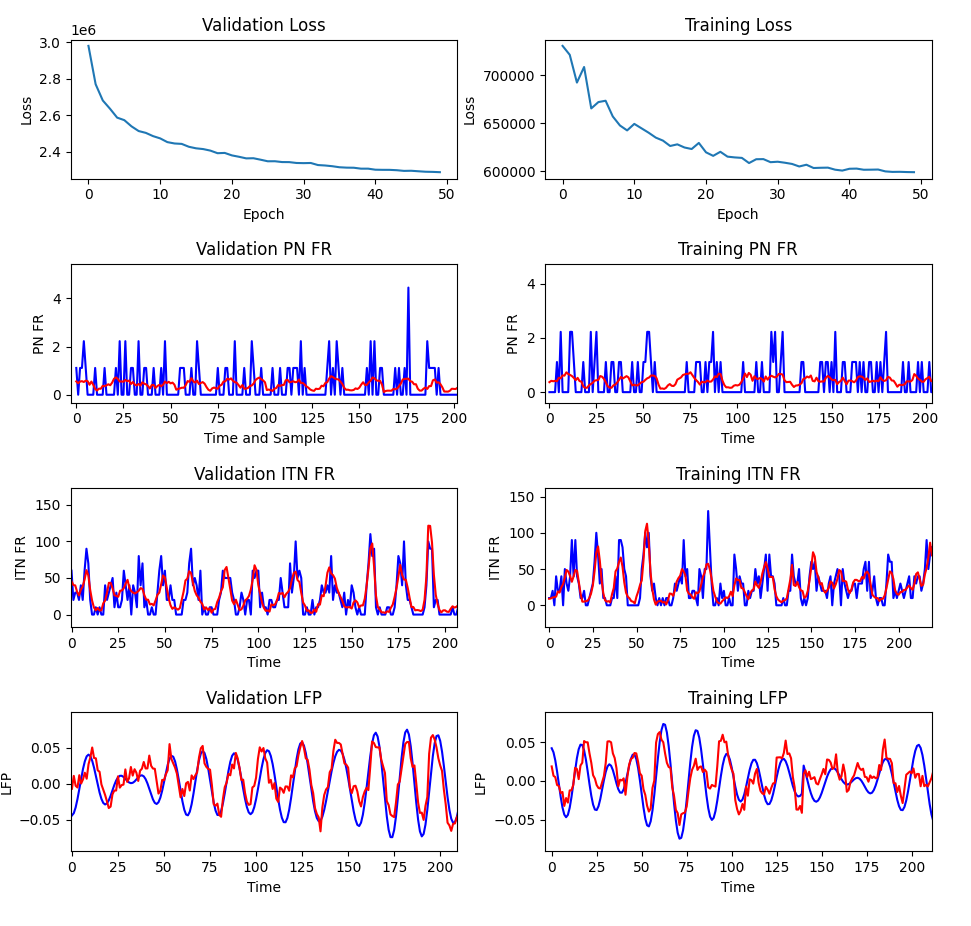

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=2)
fig.tight_layout()
ax[0,0].plot(range(epochs), pnfr_training_loss)
ax[0,0].set_title('Validation Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Epoch')

ax[0,1].plot(range(epochs), pnfr_validation_loss)
ax[0,1].set_title('Training Loss')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('Epoch')


ax[1,0].plot(np.arange(v_labels_list.shape[0]), v_labels_list[:,0], color='blue')
ax[1,0].plot(np.arange(v_labels_list.shape[0]), v_output_list[:,0], color='red')
ax[1,0].set_title('Validation PN FR')
ax[1,0].set_ylabel('PN FR')
ax[1,0].set_xlabel('Time and Sample')

ax[1,1].plot(np.arange(t_labels_list.shape[0]), t_labels_list[:,0], color='blue')
ax[1,1].plot(np.arange(t_labels_list.shape[0]), t_output_list[:,0], color='red')
ax[1,1].set_title('Training PN FR')
ax[1,1].set_ylabel('PN FR')
ax[1,1].set_xlabel('Time')

ax[2,0].plot(np.arange(v_labels_list.shape[0]), v_labels_list[:,1], color='blue')
ax[2,0].plot(np.arange(v_labels_list.shape[0]), v_output_list[:,1], color='red')
ax[2,0].set_title('Validation ITN FR')
ax[2,0].set_ylabel('ITN FR')
ax[2,0].set_xlabel('Time')

ax[2,1].plot(np.arange(t_labels_list.shape[0]), t_labels_list[:,1], color='blue')
ax[2,1].plot(np.arange(t_labels_list.shape[0]), t_output_list[:,1], color='red')
ax[2,1].set_title('Training ITN FR')
ax[2,1].set_ylabel('ITN FR')
ax[2,1].set_xlabel('Time')

ax[3,0].plot(np.arange(v_labels_list.shape[0]), v_labels_list[:,2], color='blue')
ax[3,0].plot(np.arange(v_labels_list.shape[0]), v_output_list[:,2], color='red')
ax[3,0].set_title('Validation LFP')
ax[3,0].set_ylabel('LFP')
ax[3,0].set_xlabel('Time')

ax[3,1].plot(np.arange(t_labels_list.shape[0]), t_labels_list[:,2], color='blue')
ax[3,1].plot(np.arange(t_labels_list.shape[0]), t_output_list[:,2], color='red')
ax[3,1].set_title('Training LFP')
ax[3,1].set_ylabel('LFP')
ax[3,1].set_xlabel('Time')

plt.show()